In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict

from scipy.linalg import svd
import seaborn as sns

from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import conditional_probability, joint_probability, roll_pad
from causal_optoconnectics.tools import compute_trials_multi, decompress_spikes
from causal_optoconnectics.core import Connectivity
%matplotlib inline

# Process results

In [3]:
x_i, x_j = 11, 13
y_i, y_j = 12, 19
z_i, z_j = 7, 10

def process_metadata(W, stim_index, params):
    
    pairs = []
    for i in range(params['n_neurons']):
        for j in range(params['n_neurons']):
            if i==j:
                continue
            pair = f'{i}_{j}'
            pairs.append({
                'source': i,
                'target': j,
                'pair': pair,
                'weight': W[i, j, 0],
                'source_stim': W[stim_index, i, 0] > 0,
                'source_stim_strength': W[stim_index, i, 0],
                'target_stim': W[stim_index, j, 0] > 0,
            })
    return pd.DataFrame(pairs)
    
    
def process(pair, trials, W, stim_index, params, n_trials=None):
    i, j = [int(a) for a in pair.split('_')]
    
    pre, post = trials[i], trials[j]
    
    n_trials = len(pre) if n_trials is None else n_trials
    
    conn = Connectivity(pre[:n_trials], post[:n_trials], x_i, x_j, y_i, y_j, z_i, z_j)
    
    result ={
        'source': i,
        'target': j,
        'pair': pair,
        'beta_iv': conn.beta_iv, 
        'beta': conn.beta,
        'beta_iv_did': conn.beta_iv_did, 
        'beta_did': conn.beta_did, 
        'hit_rate': conn.hit_rate,
        'weight': W[i, j, 0],
        'source_stim': W[stim_index, i, 0] > 0,
        'source_stim_strength': W[stim_index, i, 0],
        'target_stim': W[stim_index, j, 0] > 0,
    }
    return result


def compute_time_dependence(i, j, step=10000):
    pre, post = trials[i], trials[j]
    results = []
    start = 0
    for stop in tqdm(range(step, len(pre) + step, step)):
        results.append(process(i,j,stop))
    return results

In [4]:
from scipy.linalg import norm
from scipy.optimize import minimize_scalar

def error(a, df, key):
    return df['weight'] - a * df[key]

def error_norm(a, df, key):
    return norm(error(a, df, key), ord=2)

def min_error(df, key):
    return minimize_scalar(error_norm, args=(df, key)).fun

In [18]:
data_path = pathlib.Path('../scripts/confounding-3-neurons/sweep_3')

In [19]:
paths = list(data_path.glob('*.npz'))
data_df = pd.DataFrame({'path': paths})
for i, fname in enumerate(paths):
    data_df.loc[i, 'conn_strength'] = fname.stem.split('_')[-1:]
data_df = data_df.astype({'conn_strength': float})

In [20]:
data_df

,path,conn_strength
0,../scripts/confounding-3-neurons/sweep_3/conn_...,6.0
1,../scripts/confounding-3-neurons/sweep_3/conn_...,1.0
2,../scripts/confounding-3-neurons/sweep_3/conn_...,0.0
3,../scripts/confounding-3-neurons/sweep_3/conn_...,3.0
4,../scripts/confounding-3-neurons/sweep_3/conn_...,5.0
5,../scripts/confounding-3-neurons/sweep_3/conn_...,4.0
6,../scripts/confounding-3-neurons/sweep_3/conn_...,2.0
7,../scripts/confounding-3-neurons/sweep_3/conn_...,7.0


In [87]:
pbar = tqdm(total=len(data_df))
values = pd.DataFrame()
data_df = data_df.sort_values('conn_strength')
for i, row in data_df.iterrows():
    data = np.load(row.path, allow_pickle=True)
    X = data['data']
    W_0 = data['W_0']
    W = data['W']
    params = data['params'][()]
    n_neurons = params['n_neurons']
    stim_index = range(len(W))[-2]
    trials = compute_trials_multi(X, len(W_0), stim_index)
    
    results_meta = process_metadata(W=W, stim_index=stim_index, params=params)
    sample = pd.DataFrame([process(pair=pair, W=W, stim_index=stim_index, trials=trials, params=params) for pair in results_meta.pair.values])
    values = pd.concat((values, sample))
    data_df.loc[i, 'error_beta'] = min_error(sample, 'beta_did')
    data_df.loc[i, 'error_beta_iv'] = min_error(sample, 'beta_iv_did')
    
    data_df.loc[i, 'beta_AC'] = sample.query('source==0 and target==2').beta.values
    data_df.loc[i, 'beta_iv_AC'] = sample.query('source==0 and target==2').beta_iv.values
    
    data_df.loc[i, 'beta_BC'] = sample.query('source==1 and target==2').beta.values
    data_df.loc[i, 'beta_iv_BC'] = sample.query('source==1 and target==2').beta_iv.values
    pbar.update(1)
pbar.close()

  0%|          | 0/8 [00:00<?, ?it/s]

In [88]:
data_df.to_csv(data_path / 'summary.csv')

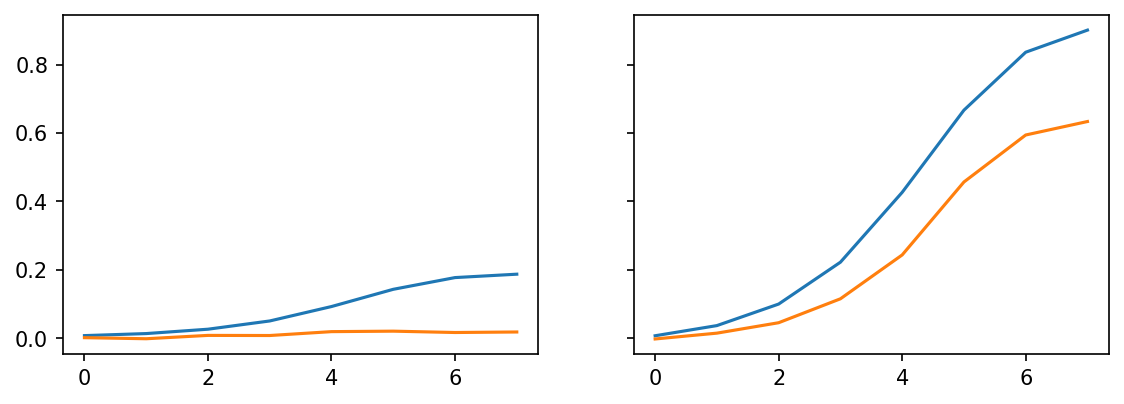

In [89]:

fig, axs = plt.subplots(1,2,dpi=150,figsize=(9,3),sharey=True,sharex=True)
axs[0].plot(data_df.conn_strength.values, data_df.beta_AC.values)
axs[0].plot(data_df.conn_strength.values, data_df.beta_iv_AC.values)

axs[1].plot(data_df.conn_strength.values, data_df.beta_BC.values)
axs[1].plot(data_df.conn_strength.values, data_df.beta_iv_BC.values)

<AxesSubplot:>

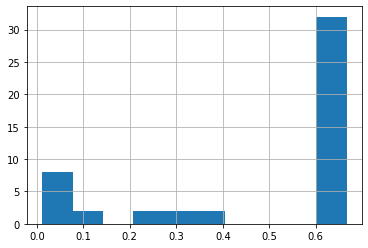

In [90]:
values.hit_rate.hist()

In [91]:
from causal_optoconnectics.buzsaki import transfer_probability

In [92]:
def convert_index_to_times(X, params):
    times = np.arange(params['n_time_step']) * params['dt']
    spikes = np.empty((sum([len(x) for x in X]),2))
    prev_t, prev_len = 0, 0
    for x in X:
        s = x.copy().astype(float)
        s[:,1] = times[x[:,1]]
        s[:,1] = s[:,1] + prev_t
        spikes[prev_len:len(s)+prev_len, :] = s
        prev_t = s[-1,1] + 100
        prev_len += len(s)
    return spikes

In [93]:
trans_prob_params = {
    'y_mu': 1.5e-3,
    'y_sigma': 1e-3,
    'bin_size': 1e-3,
    'limit': 2e-2,
    'hollow_fraction': .6,
    'width': 60
}

pbar = tqdm(total=len(data_df))
values = pd.DataFrame()
for i, row in data_df.sort_values('conn_strength').iterrows():
    data = np.load(row.path, allow_pickle=True)
    X = data['data']
    params = data['params'][()]
    spikes = convert_index_to_times(X, params)

    A_spikes = spikes[spikes[:,0]==0, 1]
    B_spikes = spikes[spikes[:,0]==1, 1]
    C_spikes = spikes[spikes[:,0]==2, 1]
    
    tr_AC = transfer_probability(A_spikes, C_spikes, **trans_prob_params)[0]
    tr_BC = transfer_probability(B_spikes, C_spikes, **trans_prob_params)[0]

    data_df.loc[i, 'tr_AC'] = tr_AC
    data_df.loc[i, 'tr_BC'] = tr_BC
    pbar.update(1)
pbar.close()

  0%|          | 0/8 [00:00<?, ?it/s]

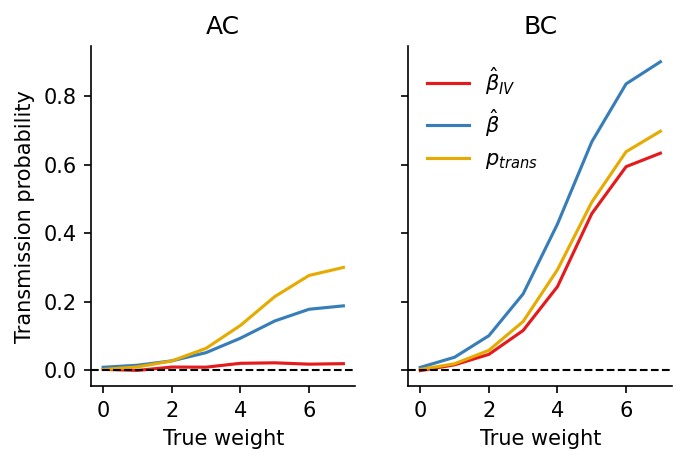

In [94]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, dpi=150, figsize=(5,3))
axba, axbb = axs.flatten()

axba.plot(data_df.conn_strength.values, data_df.beta_iv_AC.values, color='#e41a1c')

axbb.plot(data_df.conn_strength.values, data_df.beta_iv_BC.values, color='#e41a1c', label=r'$\hat{\beta}_{IV}$')

axba.plot(data_df.conn_strength.values, data_df.beta_AC.values, color='#377eb8')
axbb.plot(data_df.conn_strength.values, data_df.beta_BC.values, color='#377eb8', label=r'$\hat{\beta}$')

axba.plot(data_df.conn_strength.values, data_df.tr_AC.values, color='#e6ab02')
axbb.plot(data_df.conn_strength.values, data_df.tr_BC.values, color='#e6ab02', label=r'$p_{trans}$')

axba.axhline(0, color='k', lw=1, ls='--')
axbb.axhline(0, color='k', lw=1, ls='--')

axba.set_ylabel('Transmission probability')
axba.set_xlabel('True weight')
axbb.set_xlabel('True weight')
axba.set_title('AC')
axbb.set_title('BC')
sns.despine()
# axba.set_xticks([0,8])
# axbb.set_yticks([0,round(max(results['cond_AC']),1)])
# axbb.set_ylim([-.15,round(max(results['cond_AC']))])

axbb.legend(frameon=False)

In [95]:
from causal_optoconnectics.cch import correlogram

In [96]:
count, bins = correlogram(A_spikes, C_spikes, bin_size=trans_prob_params['bin_size'], limit=trans_prob_params['limit'])

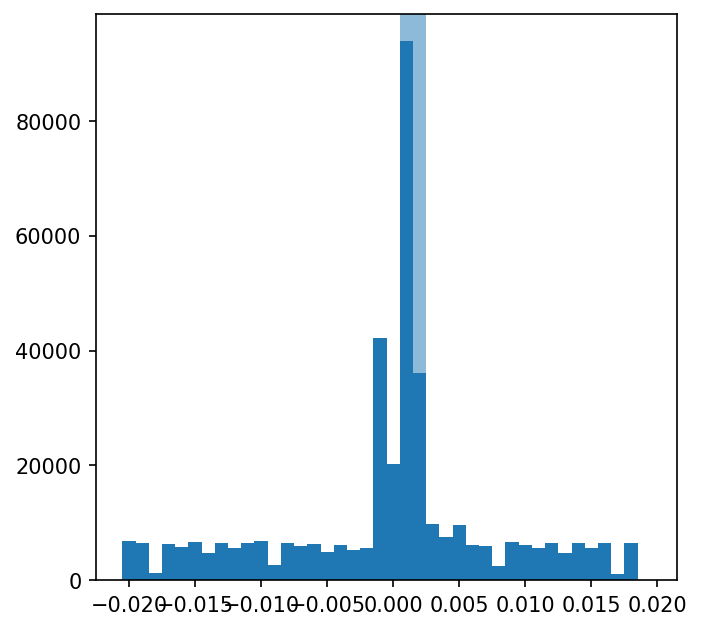

In [97]:
plt.figure(figsize=(5,5),dpi=150)
plt.bar(bins[:-1], count, width=trans_prob_params['bin_size'])
plt.axvspan(trans_prob_params['y_mu']-trans_prob_params['y_sigma'], trans_prob_params['y_mu']+trans_prob_params['y_sigma'], alpha=.5)

In [101]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

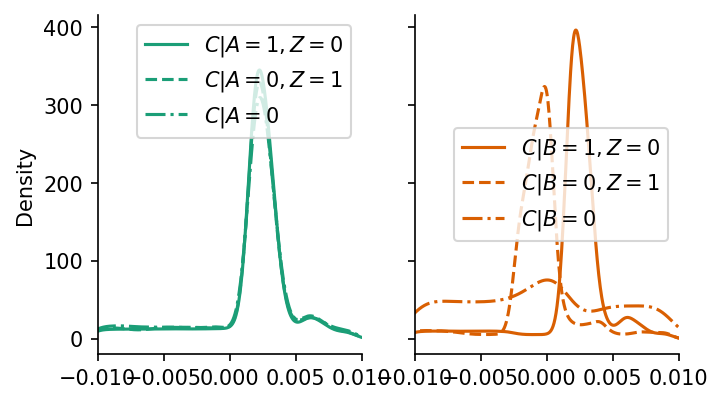

In [111]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, dpi=150, figsize=(5,3))

A, B, C = trials[0], trials[1], trials[2]

conn_A_C = Connectivity(A, C, x_i, x_j, y_i, y_j, z_i, z_j)

conn_B_C = Connectivity(B, C, x_i, x_j, y_i, y_j, z_i, z_j)

sigma = .2

times = np.arange(-10, 10) * params['dt']

spike_trials = [t for trial in C[(conn_A_C.x==1) & (conn_A_C.z==0)] for t in times[trial==1]]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[0], label='$C|A=1,Z=0$')

spike_trials = [t for trial in C[(conn_A_C.x==0) & (conn_A_C.z==1)] for t in times[trial==1]]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[0], ls='--', label='$C|A=0,Z=1$')

spike_trials = [t for trial in C[(conn_A_C.x==0)] for t in times[trial==1]]

pd.Series(spike_trials).plot.kde(ax=axs[0], bw_method=sigma, color=colors[0], ls='-.', label='$C|A=0$')

############################# B 

spike_trials = [t for trial in C[(conn_B_C.x==1) & (conn_B_C.z==0)] for t in times[trial==1]]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[1], label='$C|B=1,Z=0$')

spike_trials = [t for trial in C[(conn_B_C.x==0) & (conn_B_C.z==1)] for t in times[trial==1]]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[1], ls='--', label='$C|B=0,Z=1$')

spike_trials = [t for trial in C[(conn_B_C.x==0)] for t in times[trial==1]]

pd.Series(spike_trials).plot.kde(ax=axs[1], bw_method=sigma, color=colors[1], ls='-.', label='$C|B=0$')

axs[0].set_xlim(-0.01,0.01)
sns.despine()

axs[0].legend()
axs[1].legend()